In [18]:
import numpy as np

# Реализация QR-разложения методом Грама-Шмидта
def gram_schmidt(A):
    """Ортогонализация матрицы A методом Грама-Шмидта."""
    n, m = A.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))
    
    for j in range(m):
        v = A[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], v)
            v -= R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    
    return Q, R

# QR-алгоритм для нахождения собственных чисел
def qr_algorithm(A, tol=1e-9, max_iter=1000):
    Ak = A.copy()
    for _ in range(max_iter):
        Q, R = gram_schmidt(Ak)
        Ak_next = R @ Q
        if np.allclose(Ak, Ak_next, atol=tol):
            break
        Ak = Ak_next
    eigenvalues = np.diag(Ak)
    return eigenvalues, Q

# SVD с использованием QR-алгоритма
def svd(A, tol=1e-9, max_iter=1000):
    AtA = A.T @ A
    AAt = A @ A.T
    eigenvalues_V, V = qr_algorithm(AtA, tol, max_iter)
    eigenvalues_U, U = qr_algorithm(AAt, tol, max_iter)
    singular_values = np.sqrt(np.abs(eigenvalues_U))
    Sigma = np.diag(singular_values)
    return U, Sigma, V.T



In [19]:
!pip install matplotlib
!pip install scikit-learn


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Загружаем данные
data = load_wine()
X, y = data.data, data.target

# Оставляем только 5 признаков
X = X[:, :5]

# Стандартизация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделяем на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Минимальное число компонент для объяснения 95% дисперсии: 5


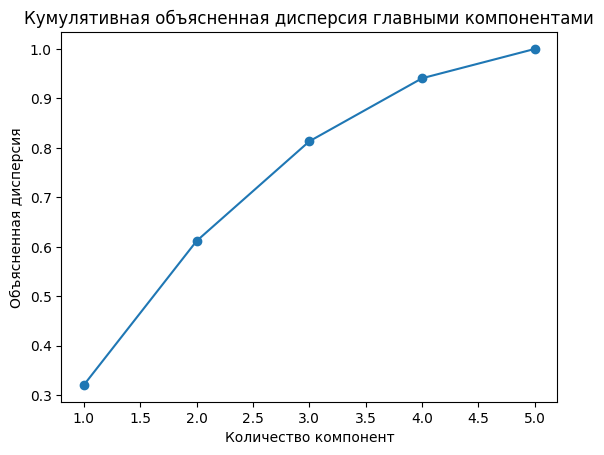

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Преобразование данных с использованием PCA
def pca(X, num_components):
    """Метод главных компонент на основе SVD."""
    U, S, V = np.linalg.svd(X, full_matrices=False)  # SVD разложение
    X_transformed = X @ V.T[:, :num_components]  # Преобразование данных
    
    # Объясненная дисперсия на основе квадратов сингулярных значений
    explained_variance = np.cumsum(S[:num_components]**2) / np.sum(S**2)
    
    return X_transformed, explained_variance, V

# Применяем PCA с различным количеством компонент
X_train_pca, explained_variance, V = pca(X_train, num_components=5)  # исправленный вызов с возвратом V

# Определим минимальное число компонент, объясняющих 95% дисперсии
num_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Минимальное число компонент для объяснения 95% дисперсии: {num_components}")

# Визуализация кумулятивной доли объясненной дисперсии
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title('Кумулятивная объясненная дисперсия главными компонентами')
plt.xlabel('Количество компонент')
plt.ylabel('Объясненная дисперсия')
plt.show()



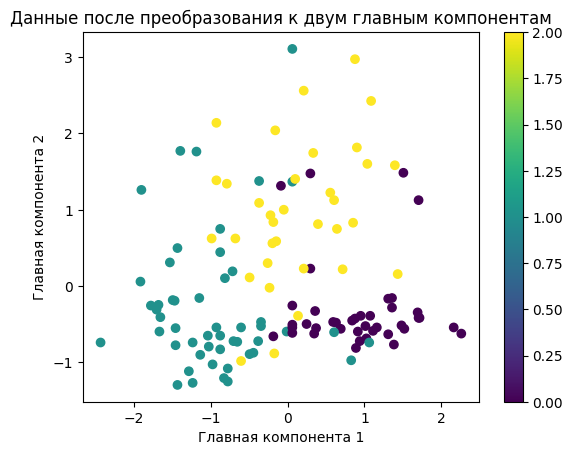

In [21]:
# Преобразование до 2 главных компонент для визуализации
X_train_pca_2d, _ = pca(X_train, 2)

# Визуализация данных в пространстве главных компонент
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train, cmap='viridis')
plt.title('Данные после преобразования к двум главным компонентам')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.colorbar()
plt.show()


In [31]:
import time
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

# Обучение модели без PCA
start_time = time.time()
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)
training_time_no_pca = time.time() - start_time
y_pred = mlp.predict(X_test)
accuracy_no_pca = accuracy_score(y_test, y_pred)
print(f"Точность без PCA: {accuracy_no_pca:.4f}")
print(f"Время обучения без PCA: {training_time_no_pca:.4f} секунд")

# Обучение модели с PCA
X_train_pca, _, V = pca(X_train, num_components)  # Обязательно получаем V
X_test_pca = X_test @ V.T[:, :num_components]  # Применяем ту же матрицу V для тестовых данных

start_time = time.time()
mlp_pca = MLPClassifier(random_state=42, max_iter=1000)
mlp_pca.fit(X_train_pca, y_train)
training_time_pca = time.time() - start_time
y_pred_pca = mlp_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Точность с PCA: {accuracy_pca:.4f}")
print(f"Время обучения с PCA: {training_time_pca:.4f} секунд")



Точность без PCA: 0.8704
Время обучения без PCA: 0.1953 секунд
Точность с PCA: 0.8519
Время обучения с PCA: 0.1731 секунд


In [33]:
#Оптимизация вычислительной сложности (Методы с пониженным рангом)
import numpy as np

def power_iteration(A, num_simulations: int):
    # Начальный вектор (размерность = количество столбцов A)
    b_k = np.random.rand(A.shape[1])  # A.shape[1] даст количество столбцов (входных признаков)
    
    for _ in range(num_simulations):
        # Переумножаем на матрицу
        b_k1 = np.dot(A.T, np.dot(A, b_k))  # Умножаем на A^T * A
        # Нормализуем вектор
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1 / b_k1_norm  # Нормализация
    
    return b_k

# Пример использования для нахождения ведущего сингулярного значения
leading_vector = power_iteration(X_train, 100)
print("Ведущий сингулярный вектор:", leading_vector)


Ведущий сингулярный вектор: [-0.41105733  0.34474078  0.32457554  0.71974654 -0.29799548]
